### MSCI 598 - Final Project
### Gaurav Mudbhatkal - 20747018

In [1]:
import pandas as pd
import numpy as np
import os
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

from keras.models import Input,Model,Sequential
from keras.layers import LSTM,Embedding,Dropout,Activation,Reshape,Dense,GRU,Add,Flatten,concatenate

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences

In [2]:
from feature_engineering import refuting_features, polarity_features, hand_features, gen_or_load_feats
from feature_engineering import word_overlap_features
from feature_engineering import clean, normalize_word, get_tokenized_lemmas, remove_stopwords
from utils.dataset import DataSet
from utils.generate_test_splits import kfold_split, get_stances_for_folds
from utils.score import report_score, LABELS, score_submission

from utils.system import parse_params, check_version

d = DataSet()

Reading dataset
Total stances: 49972
Total bodies: 1683


#### Data Processing

In [3]:
from tqdm import tqdm
def get_data(stances, dataset):
    h, b, y = [], [], []
    for stance in stances:
        y.append(LABELS.index(stance['Stance']))
        h.append(stance['Headline'])
        b.append(dataset.articles[stance['Body ID']])
    X = []
    headlines = []
    bodies = []
    for i, (headline, body) in tqdm(enumerate(zip(h, b))):
        headlines.append(headline)
        bodies.append(body)
    df = pd.DataFrame(list(zip(headlines,bodies, y)), columns=['headlines','bodies','stances'])
    return df
df = get_data(d.stances,d)

49972it [00:00, 2084388.40it/s]


In [5]:
fnc_df = df
corpus = np.r_[fnc_df['headlines'].values,fnc_df['bodies'].values]

vocabulary = []
for sentence in corpus:
    vocabulary.extend(sentence.split(' '))

vocabulary = list(set(vocabulary))
vocab_length = len(vocabulary)
print("Vocabulary Length is {0}".format(vocab_length))

Vocabulary Length is 64510


In [6]:
max_features = 5000
max_nb_words = 24000
EMBEDDING_DIM = 50
MAX_SEQUENCE_LENGTH_HEADLINE = 100
MAX_SEQUENCE_LENGTH_BODY = 100

In [7]:
# one-hot encoding
encoded_docs_headline = [one_hot(sentence,vocab_length) for sentence in fnc_df.loc[:,'headlines'].tolist()]
padded_docs_headline = pad_sequences(encoded_docs_headline,MAX_SEQUENCE_LENGTH_HEADLINE,padding='post')

encoded_docs_body = [one_hot(sentence,vocab_length) for sentence in fnc_df.loc[:,'bodies'].tolist()]
padded_docs_body = pad_sequences(encoded_docs_body,MAX_SEQUENCE_LENGTH_BODY,padding='post')

from keras.utils.np_utils import to_categorical 
labels = to_categorical(fnc_df.loc[:,'stances'])

#### LSTM with Two Inputs

In [8]:
# separate layers for headlines and bodies
headline_input = Input(shape=[MAX_SEQUENCE_LENGTH_HEADLINE],name='headline_input')

headline_embedding = Embedding(vocab_length,50,input_length = MAX_SEQUENCE_LENGTH_HEADLINE)(headline_input)

body_input = Input(shape=[MAX_SEQUENCE_LENGTH_BODY],name='body_input')

body_embedding = Embedding(vocab_length,50,input_length = MAX_SEQUENCE_LENGTH_BODY)(body_input)

# concatenate layers
layer_concat = concatenate([headline_embedding,body_embedding])

lstm = LSTM(units=64)(layer_concat)

output = Dense(4,activation='softmax')(lstm)

model_combined = Model(inputs=[headline_input,body_input],outputs=output)

model_combined.compile(optimizer = 'adam',loss ='categorical_crossentropy',metrics = ['accuracy'])

In [9]:
model_combined.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 headline_input (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 body_input (InputLayer)        [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 50)      3225500     ['headline_input[0][0]']         
                                                                                                  
 embedding_1 (Embedding)        (None, 100, 50)      3225500     ['body_input[0][0]']             
                                                                                              

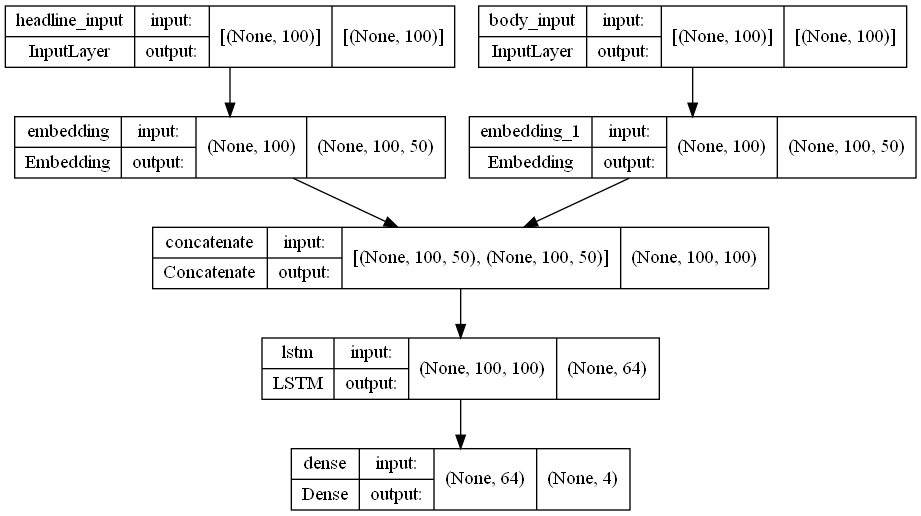

In [10]:
from tensorflow.keras.utils import plot_model
plot_model(model_combined, to_file='model_one_hot.png', show_shapes=True, show_layer_names=True)

In [11]:
train_headlines = padded_docs_headline[:int(len(padded_docs_headline)*0.8),:]
val_headlines = padded_docs_headline[int(len(padded_docs_headline)*0.8):,:]

train_bodies = padded_docs_body[:int(len(padded_docs_body)*0.8),:]
val_bodies = padded_docs_body[int(len(padded_docs_body)*0.8):,:]

train_labels = labels[:int(len(labels)*0.8),:]
val_labels = labels[int(len(labels)*0.8):,:]

In [12]:
model_combined.fit([train_headlines,train_bodies],train_labels,epochs=15,verbose=1,validation_data=([val_headlines,val_bodies],val_labels))

Epoch 1/15
1250/1250 [==============================] - 134s 105ms/step - loss: 0.6547 - accuracy: 0.7705 - val_loss: 0.5582 - val_accuracy: 0.7991
Epoch 2/15
1250/1250 [==============================] - 132s 106ms/step - loss: 0.5243 - accuracy: 0.8083 - val_loss: 0.4900 - val_accuracy: 0.8262
Epoch 3/15
1250/1250 [==============================] - 133s 107ms/step - loss: 0.4558 - accuracy: 0.8377 - val_loss: 0.4443 - val_accuracy: 0.8438
Epoch 4/15
1250/1250 [==============================] - 132s 106ms/step - loss: 0.4052 - accuracy: 0.8549 - val_loss: 0.4411 - val_accuracy: 0.8486
Epoch 5/15
1250/1250 [==============================] - 137s 110ms/step - loss: 0.3568 - accuracy: 0.8723 - val_loss: 0.3929 - val_accuracy: 0.8601
Epoch 6/15
1250/1250 [==============================] - 122s 98ms/step - loss: 0.3196 - accuracy: 0.8860 - val_loss: 0.3884 - val_accuracy: 0.8623
Epoch 7/15
1250/1250 [==============================] - 123s 99ms/step - loss: 0.2949 - accuracy: 0.8922 - val_lo

In [20]:
competition_dataset = DataSet("competition_test")

competition_df = get_data(competition_dataset.stances,competition_dataset)

# one-hot encoding
encoded_docs_headline_competition = [one_hot(sentence,vocab_length) for sentence in competition_df.loc[:,'headlines'].tolist()]
padded_docs_headline_competition = pad_sequences(encoded_docs_headline_competition,MAX_SEQUENCE_LENGTH_HEADLINE,padding='post')

encoded_docs_body_competition = [one_hot(sentence,vocab_length) for sentence in competition_df.loc[:,'bodies'].tolist()]
padded_docs_body_competition = pad_sequences(encoded_docs_body_competition,MAX_SEQUENCE_LENGTH_BODY,padding='post')

from keras.utils.np_utils import to_categorical 
labels_competition = to_categorical(competition_df.loc[:,'stances'])

Reading dataset
Total stances: 25413
Total bodies: 904


25413it [00:00, 1812290.19it/s]


In [21]:
preds = model_combined.predict([padded_docs_headline_competition, padded_docs_body_competition])

In [22]:
predicted = [LABELS[int(np.argmax(a))] for a in preds]
actual = [LABELS[int(np.argmax(a))] for a in labels_competition]
report_score(actual, predicted)

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    409    |    11     |    371    |   1112    |
-------------------------------------------------------------
| disagree  |    168    |     6     |    116    |    407    |
-------------------------------------------------------------
|  discuss  |    764    |    33     |   1271    |   2396    |
-------------------------------------------------------------
| unrelated |   2626    |    149    |   4399    |   11175   |
-------------------------------------------------------------
Score: 4845.5 out of 11651.25	(41.58781246647355%)


41.58781246647355

In [23]:
from sklearn.metrics import precision_score, recall_score
precision_score(actual,predicted, average='macro'), recall_score(actual,predicted, average='macro')

(0.2700599243359111, 0.27931984077648164)